#### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# <center><font color=7E4456>GRIP - TSF</font></center>

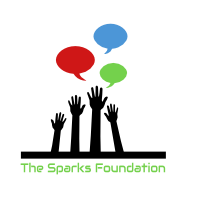

#### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### <center><font color=7E4456>Data Science and Business Analytics Internship

### <center><font color=7E4456>By </font><font color=15D77D>: </font><font color=5B1736>Shreeya Ravindra Pant-Paradkar</font></center>
#### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# <center><font color=5B4727>Stock Market Prediction using Numerical and Textual Analysis</font></center>
### <center><font color=5B4727>(Level - Advanced)</font></center>
# <center><font color=14655D>Task 7 : Numerical and Textual Analysis</font></center>
### <center><font color=155E64>Problem Statement: </font><font color=5B4727>To create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices and sentimental analysis of news headline</font>
#### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

###### Date: 19-12-20 (Saturday)

### 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import math

# For time stamps
from datetime import datetime

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For sentiments
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

# Model Building
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

# Preprocessing & Data Evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing, metrics


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")


import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.

Bad key "text.kerning_factor" on line 4 in
C:\Users\HRISHIKESH\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
C:\Users\HRISHIKESH\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
### Reading News Headlines data

In [3]:
news_headlines = pd.read_csv('data/india-news-headlines.csv')
# displaying news headlines dataset
news_headlines.head()

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [4]:
# Identifying total numbers of records in both the datasets
print("Total records in News Headlines Datasets: {}".format(len(news_headlines)))

Total records in News Headlines Datasets: 3297172


In [5]:
print(news_headlines.isna().any())

publish_date         False
headline_category    False
headline_text        False
dtype: bool


In [6]:
news_headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297172 entries, 0 to 3297171
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 75.5+ MB


In [7]:
news_headlines['headline_category'].value_counts()

india                      285619
unknown                    207732
city.mumbai                132649
city.delhi                 124658
business.india-business    115246
                            ...  
ballot-talk                     7
sports.headline3                7
did-you-know                    6
sports.headline6                3
party-manifestos                2
Name: headline_category, Length: 1016, dtype: int64

In [8]:
#### top 10 categories

In [9]:
news_headlines['headline_category'].value_counts().head(10)

india                            285619
unknown                          207732
city.mumbai                      132649
city.delhi                       124658
business.india-business          115246
city.chandigarh                  107464
city.hyderabad                    99014
city.bengaluru                    91857
entertainment.hindi.bollywood     90374
city.ahmedabad                    85813
Name: headline_category, dtype: int64

In [10]:
# dropping duplicates if any
news_headlines1 = news_headlines.drop_duplicates()

# Coverting the datatype of column 'Date' from  object to 'datetime'
news_headlines1['publish_date'] = news_headlines1['publish_date'].astype(str)
news_headlines1['publish_date'] = news_headlines1['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
news_headlines1['publish_date'] = pd.to_datetime(news_headlines1['publish_date']).dt.normalize()

# filtering the important columns required
news_headlines1 = news_headlines1.filter(['publish_date', 'headline_text'])

# Grouping the news headlines according to 'Publish_Date'
news_headlines1 = news_headlines1.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
news_headlines1.set_index('publish_date', inplace= True)

# Sorting the data according to Date
news_headlines1 = news_headlines1.sort_index(ascending=True, axis=0)
news_headlines1

,headline_text
publish_date,
2001-01-01,win over cena satisfying but defeating underta...
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
...,...
2020-06-26,Containment zone residents slam high prices ch...
2020-06-27,like me i wont let you have a toxic relationsh...
2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...


In [11]:
print("Maximum from dataset:\n", news_headlines1.max())

Maximum from dataset:
 headline_text    you dont have to be a jeanius to wear white,La...
dtype: object


In [12]:
print("minimum from dataset:\n", news_headlines1.min())

minimum from dataset:
 headline_text    #CoronaCrisis With fashion shows being called ...
dtype: object


In [13]:
from wordcloud import WordCloud, STOPWORDS

In [14]:
news_text = '' 
stopwords = set(STOPWORDS) 
nws=news_headlines.head(20000)

# iterate through the csv file 
for val in nws.headline_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    news_text += " ".join(tokens)+" "

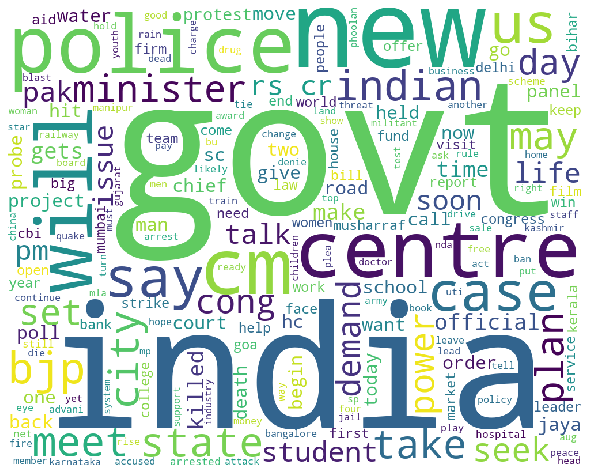

In [15]:
wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(news_text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [16]:
# The tech companies (Apple, Google, Microsoft, and Amazon) stocks we'll use for this analysis
tech_list = ['TWTR', 'SNAP', 'PINS', 'FB']

# Seting up End and Start times for data fetching
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)


#For loop for fetching yahoo finance data and setting as a dataframe
for stock in tech_list:   
    # Seting DataFrame as the Stock Ticker
    globals()[stock] = DataReader(stock, 'yahoo', start, end)

In [17]:
company_list = [TWTR, SNAP, PINS, FB]
company_name = ['TWTR', 'SNAP', 'PINS', 'FB']

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)

In [18]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2019-12-17,31.209999,30.629999,31.070000,30.700001,11906500,30.700001,TWTR
2019-12-18,31.910000,30.629999,30.690001,31.680000,19030900,31.680000,TWTR
2019-12-19,32.419998,31.610001,31.750000,32.029999,19880000,32.029999,TWTR
2019-12-20,32.250000,31.540001,32.119999,32.130001,21854600,32.130001,TWTR
2019-12-23,32.799999,31.990000,32.130001,32.430000,13983300,32.430000,TWTR


In [19]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2020-12-11,276.480011,270.250000,274.529999,273.549988,14391400,273.549988,FB
2020-12-14,277.220001,271.559998,273.369995,274.190002,16376900,274.190002,FB
2020-12-15,276.079987,267.470001,274.829987,275.549988,23979500,275.549988,FB
2020-12-16,277.859985,272.510010,274.760010,275.670013,15885000,275.670013,FB
2020-12-17,280.440002,273.609985,277.070007,274.480011,16367000,274.480011,FB


In [20]:
# Summary Stats of Twitter stocks
TWTR.describe()

,High,Low,Open,Close,Volume,Adj Close
count,254.000000,254.000000,254.000000,254.000000,2.540000e+02,254.000000
mean,37.086614,35.633346,36.334803,36.399055,1.977340e+07,36.399055
std,7.072677,7.027074,7.004587,7.083309,1.313219e+07,7.083309
min,23.490000,20.000000,22.110001,22.000000,4.290500e+06,22.000000
25%,32.419998,31.275000,31.762500,32.029999,1.228058e+07,32.029999
50%,36.190001,34.750000,35.740000,35.405001,1.710585e+07,35.405001
75%,41.572499,40.237500,40.985002,41.132502,2.246045e+07,41.132502
max,56.110001,53.939999,54.770000,54.630001,1.096547e+08,54.630001


In [21]:
# Summary Stats of Snapchat stocks
SNAP.describe()

,High,Low,Open,Close,Volume,Adj Close
count,254.000000,254.000000,254.000000,254.000000,2.540000e+02,254.000000
mean,23.785705,22.690327,23.197874,23.297598,3.000077e+07,23.297598
std,10.584767,10.048627,10.284624,10.373220,2.601339e+07,10.373220
min,9.080000,7.890000,8.030000,8.370000,7.690700e+06,8.370000
25%,17.182500,16.502500,16.840000,16.922500,1.843818e+07,16.922500
50%,21.607500,20.725000,21.215000,21.210000,2.415495e+07,21.210000
75%,25.700000,24.449999,25.175001,25.167500,3.198750e+07,25.167500
max,54.709999,51.900002,53.680000,53.330002,2.543631e+08,53.330002


In [22]:
# Summary Stats of Pinterest stocks
PINS.describe()

,High,Low,Open,Close,Volume,Adj Close
count,254.000000,254.000000,254.000000,254.000000,2.540000e+02,254.000000
mean,31.938374,30.298004,31.145335,31.190591,1.516125e+07,31.190591
std,16.784913,15.999383,16.453963,16.461401,1.253337e+07,16.461401
min,12.400000,10.100000,10.600000,10.920000,2.014300e+06,10.920000
25%,19.831000,18.905000,19.257500,19.500000,9.371400e+06,19.500000
50%,24.170000,23.080000,23.550000,23.410001,1.222675e+07,23.410001
75%,38.559999,36.520000,37.702499,38.172501,1.635072e+07,38.172501
max,72.879997,70.099998,72.169998,71.639999,1.281018e+08,71.639999


In [23]:
# Summary Stats of Facebook stocks
FB.describe()

,High,Low,Open,Close,Volume,Adj Close
count,254.000000,254.000000,254.000000,254.000000,2.540000e+02,254.000000
mean,235.362127,228.356969,231.837992,232.050670,2.231938e+07,232.050670
std,38.577249,38.094504,38.402378,38.193829,1.048792e+07,38.193829
min,148.179993,137.100006,139.750000,146.009995,6.046300e+06,146.009995
25%,209.937496,205.227497,206.945000,207.340000,1.540148e+07,207.340000
50%,235.475006,230.070000,231.815002,233.004997,2.008545e+07,233.004997
75%,270.364998,262.075012,265.485001,265.772491,2.646915e+07,265.772491
max,304.670013,293.049988,300.160004,303.910004,7.634390e+07,303.910004


In [24]:
# General Apple stocks info
TWTR.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2019-12-17 to 2020-12-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   High          254 non-null    float64
 1   Low           254 non-null    float64
 2   Open          254 non-null    float64
 3   Close         254 non-null    float64
 4   Volume        254 non-null    int64  
 5   Adj Close     254 non-null    float64
 6   company_name  254 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.9+ KB


In [25]:
# General Apple stocks info
SNAP.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2019-12-17 to 2020-12-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   High          254 non-null    float64
 1   Low           254 non-null    float64
 2   Open          254 non-null    float64
 3   Close         254 non-null    float64
 4   Volume        254 non-null    int64  
 5   Adj Close     254 non-null    float64
 6   company_name  254 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.9+ KB


In [26]:
# General Apple stocks info
PINS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2019-12-17 to 2020-12-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   High          254 non-null    float64
 1   Low           254 non-null    float64
 2   Open          254 non-null    float64
 3   Close         254 non-null    float64
 4   Volume        254 non-null    int64  
 5   Adj Close     254 non-null    float64
 6   company_name  254 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.9+ KB


In [27]:
# General Apple stocks info
FB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2019-12-17 to 2020-12-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   High          254 non-null    float64
 1   Low           254 non-null    float64
 2   Open          254 non-null    float64
 3   Close         254 non-null    float64
 4   Volume        254 non-null    int64  
 5   Adj Close     254 non-null    float64
 6   company_name  254 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.9+ KB


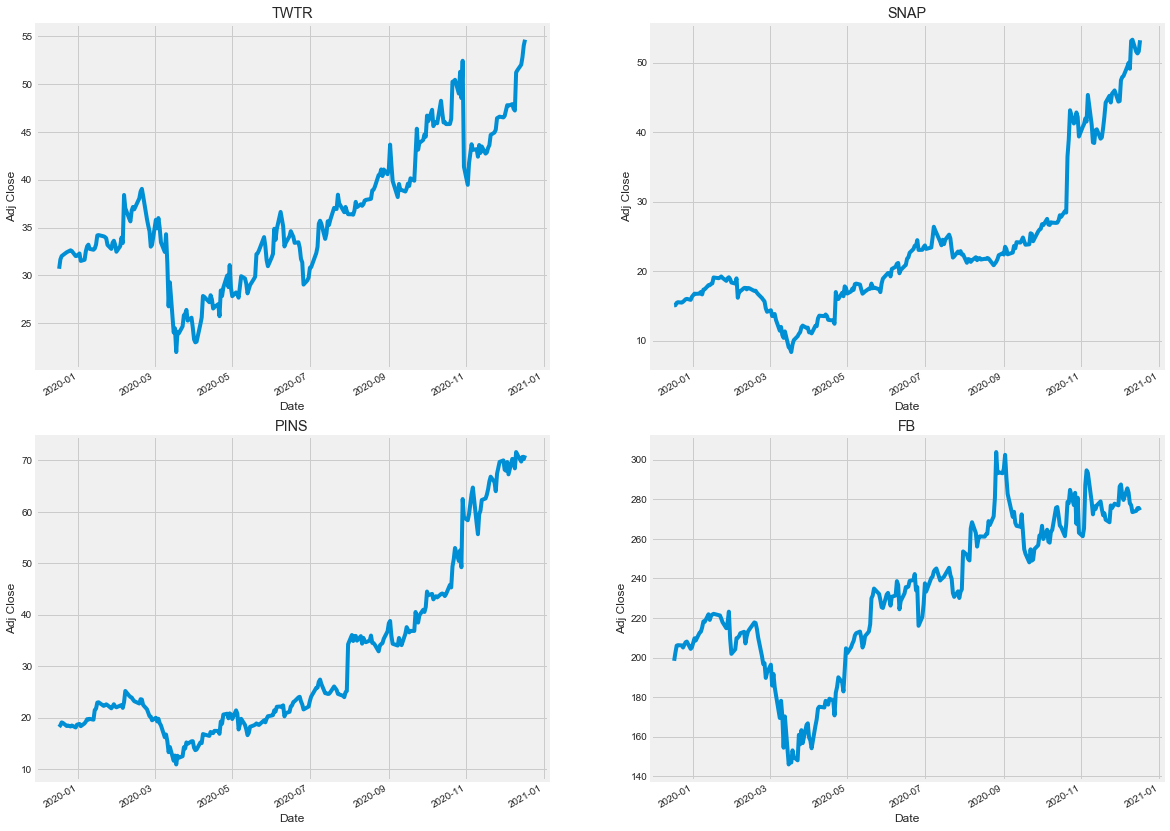

In [28]:
# Let's see a historical change in the closing price overtime
plt.figure(figsize=(18, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel('Date')
    plt.title(f"{tech_list[i - 1]}")

In [29]:
### The total volume of stock being traded each day

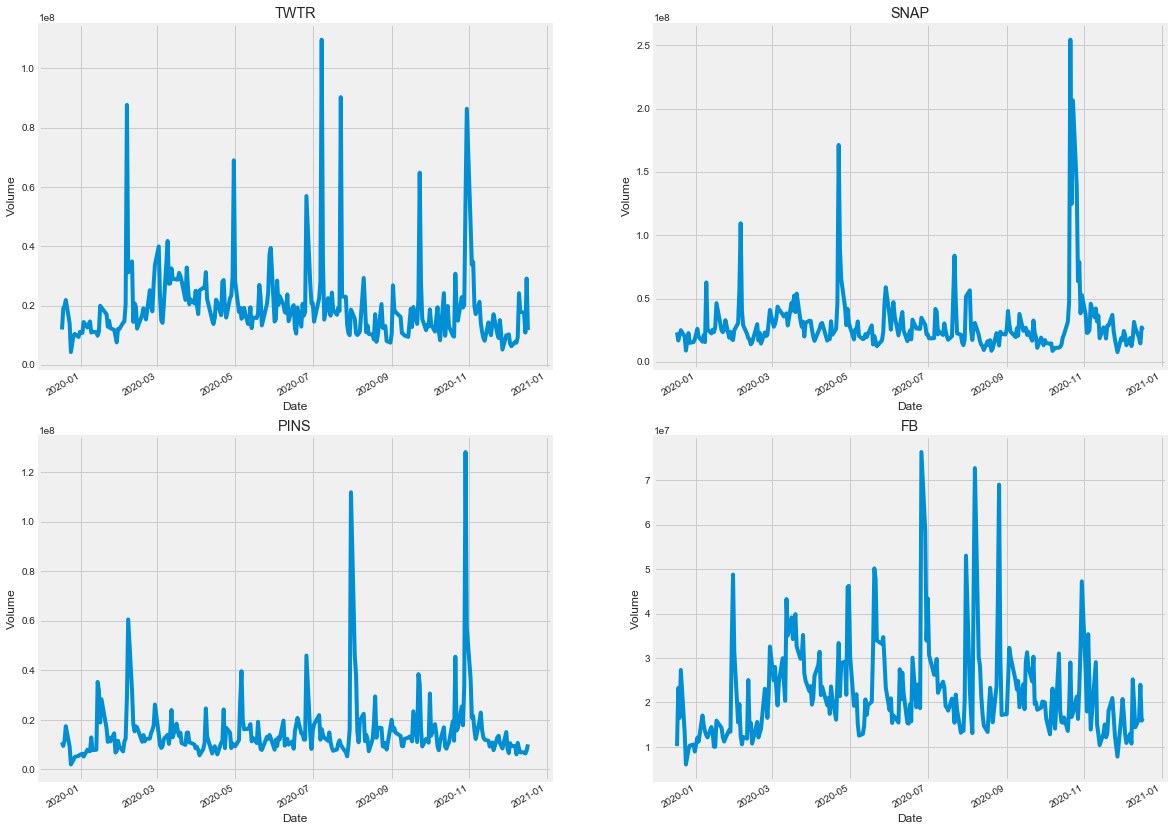

In [30]:
plt.figure(figsize=(18, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel("Date")
    plt.title(f"{tech_list[i - 1]}")

In [31]:
### The Max High of stock being traded each day

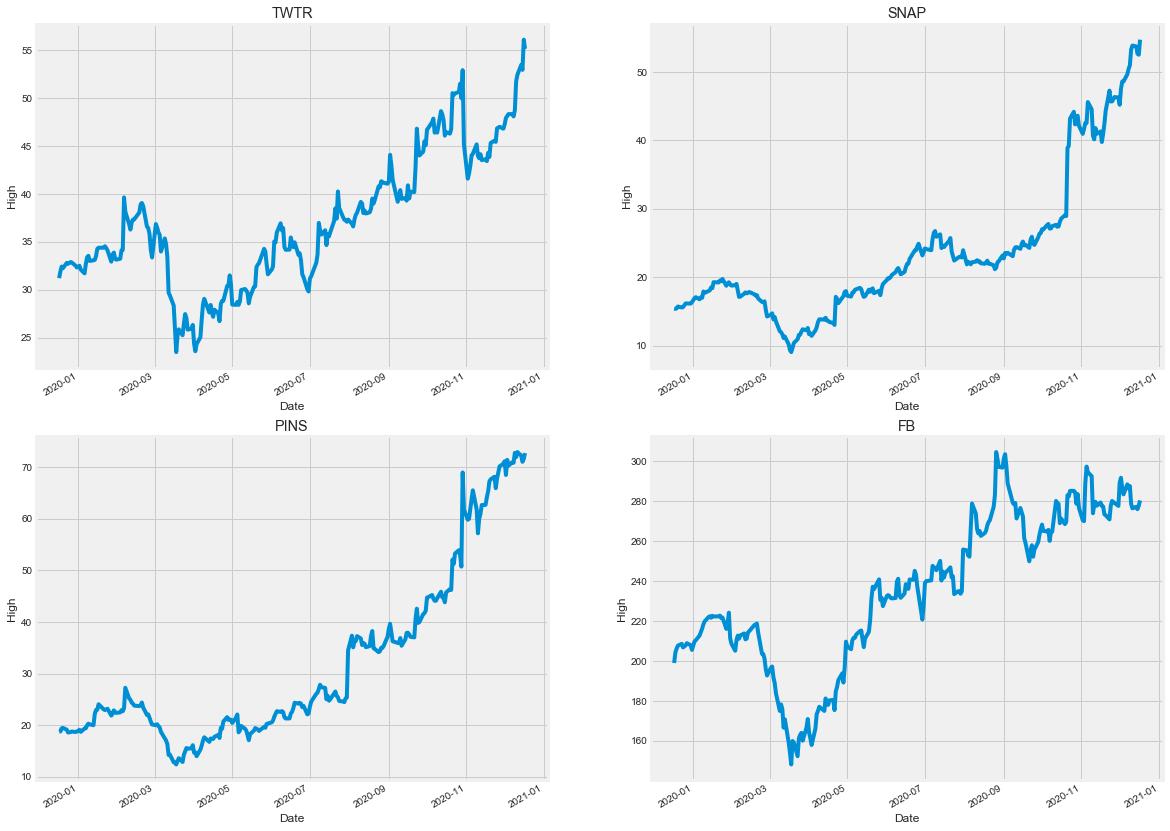

In [32]:
plt.figure(figsize=(18, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['High'].plot()
    plt.ylabel('High')
    plt.xlabel("Date")
    plt.title(f"{tech_list[i - 1]}")

In [33]:
### The moving average of the various stocks

In [34]:
moving_avg_day = [10, 20, 50]

for mv_avg in moving_avg_day:
    for company in company_list:
        column_name = f"MA for {mv_avg} days"
        company[column_name] = company['Adj Close'].rolling(mv_avg).mean()

In [35]:
print(TWTR.columns)
print(' ')
print(SNAP.columns)
print(' ')
print(PINS.columns)
print(' ')
print(FB.columns)

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'company_name',
       'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
      dtype='object')
 
Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'company_name',
       'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
      dtype='object')
 
Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'company_name',
       'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
      dtype='object')
 
Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'company_name',
       'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
      dtype='object')


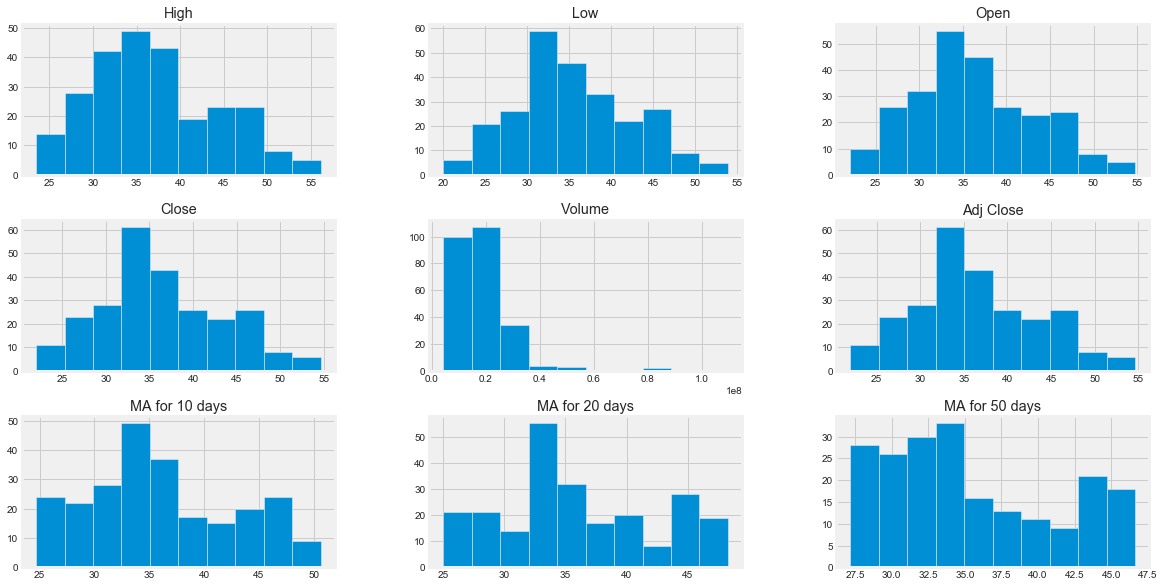

In [36]:
TWTR.groupby("company_name").hist(figsize=(18, 10));

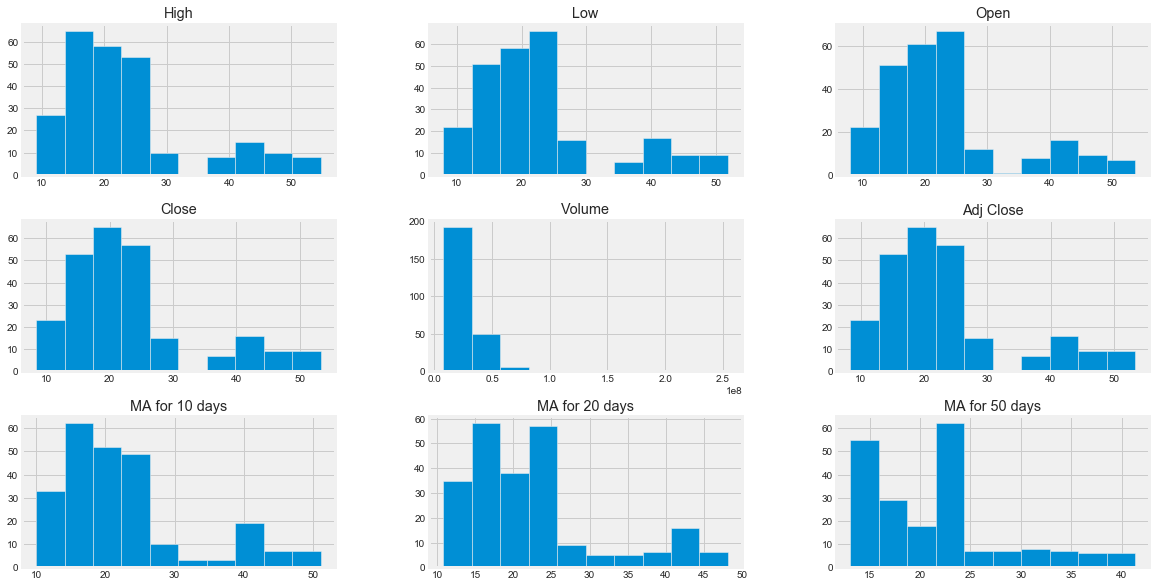

In [37]:
SNAP.groupby("company_name").hist(figsize=(18, 10));

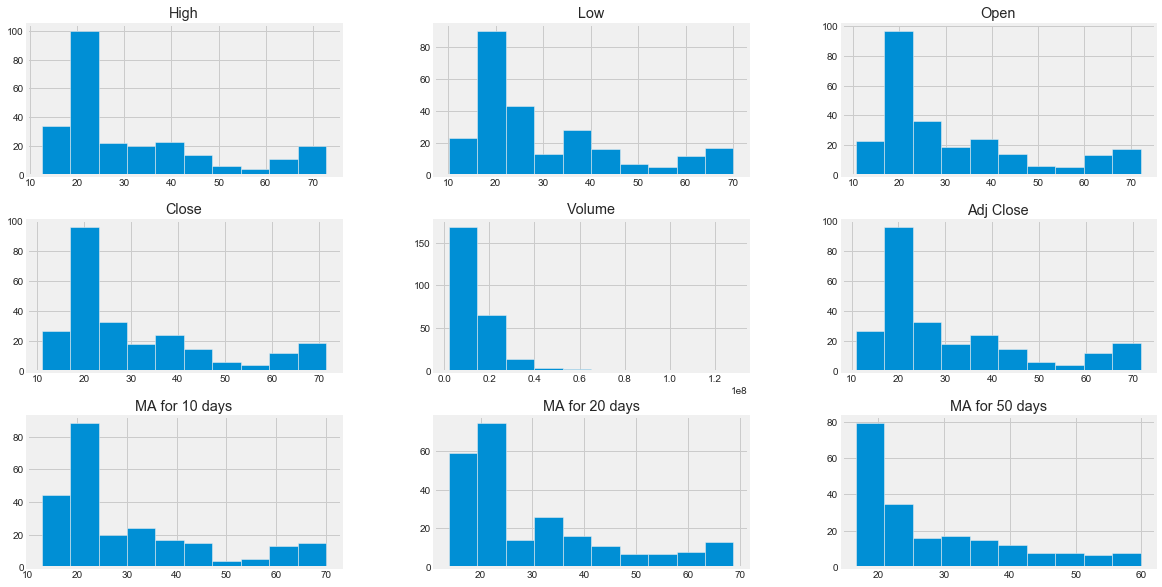

In [38]:
PINS.groupby("company_name").hist(figsize=(18, 10));

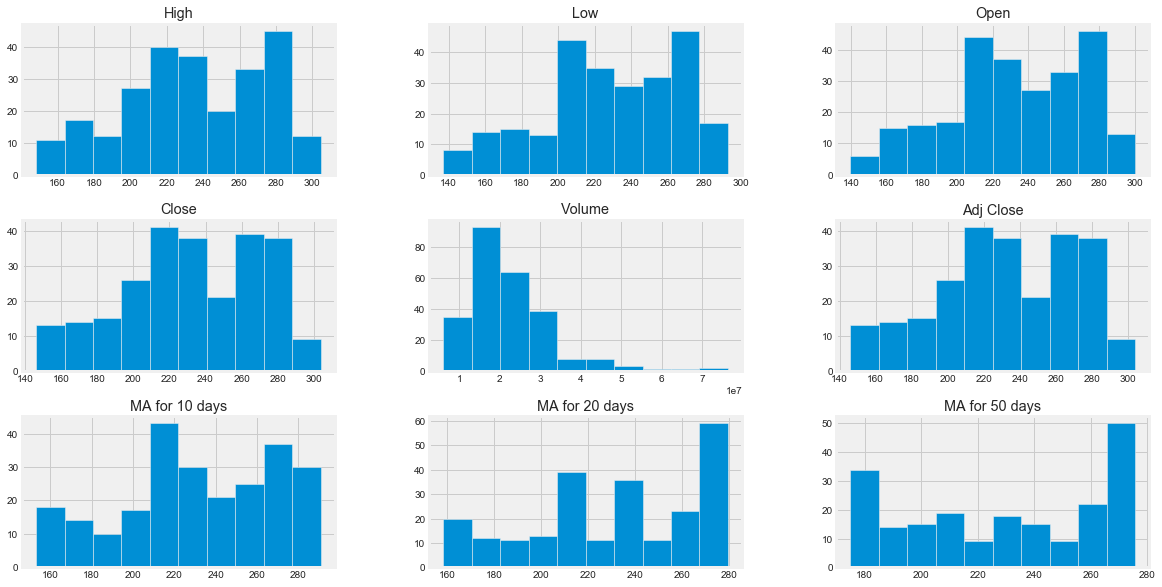

In [39]:
FB.groupby("company_name").hist(figsize=(18, 10));

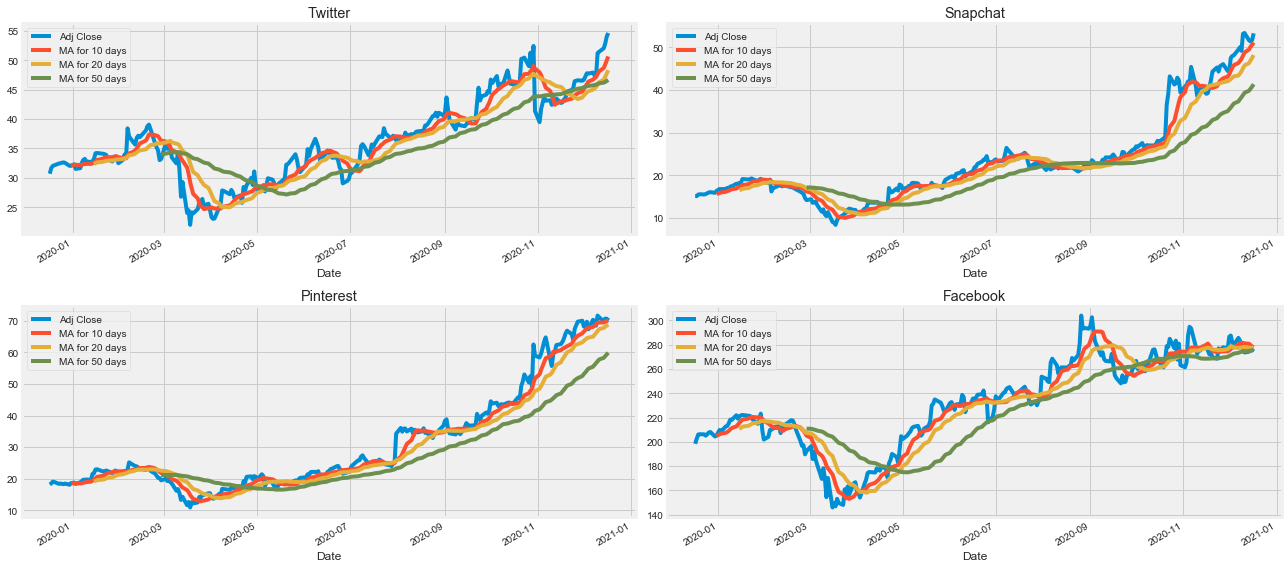

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(18)

TWTR[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax[0,0])
ax[0,0].set_title('Twitter')

SNAP[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax[0,1])
ax[0,1].set_title('Snapchat')

PINS[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax[1,0])
ax[1,0].set_title('Pinterest')

FB[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax[1,1])
ax[1,1].set_title('Facebook')

fig.tight_layout()

In [41]:
### The daily return of the stock on average

In [42]:
# Here I have used **pct_change** to find the percentage change in each day

for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

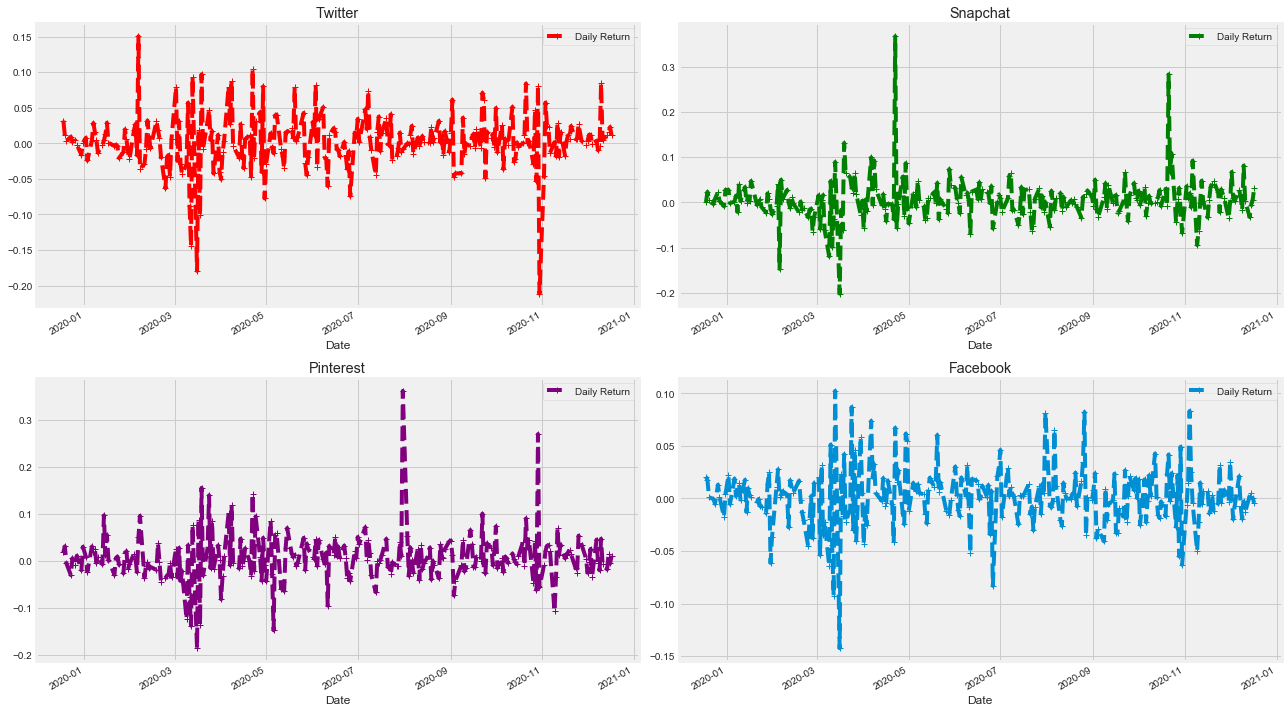

In [43]:
# Ploting the daily return percentage
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(18)

TWTR['Daily Return'].plot(ax=ax[0,0], legend=True, linestyle='--', marker='+',color='red')
ax[0,0].set_title('Twitter')

SNAP['Daily Return'].plot(ax=ax[0,1], legend=True, linestyle='--', marker='+',color='green')
ax[0,1].set_title('Snapchat')

PINS['Daily Return'].plot(ax=ax[1,0], legend=True, linestyle='--', marker='+',color='purple')
ax[1,0].set_title('Pinterest')

FB['Daily Return'].plot(ax=ax[1,1], legend=True, linestyle='--', marker='+')
ax[1,1].set_title('Facebook')

fig.tight_layout()

In [44]:
### average daily return using a histogram

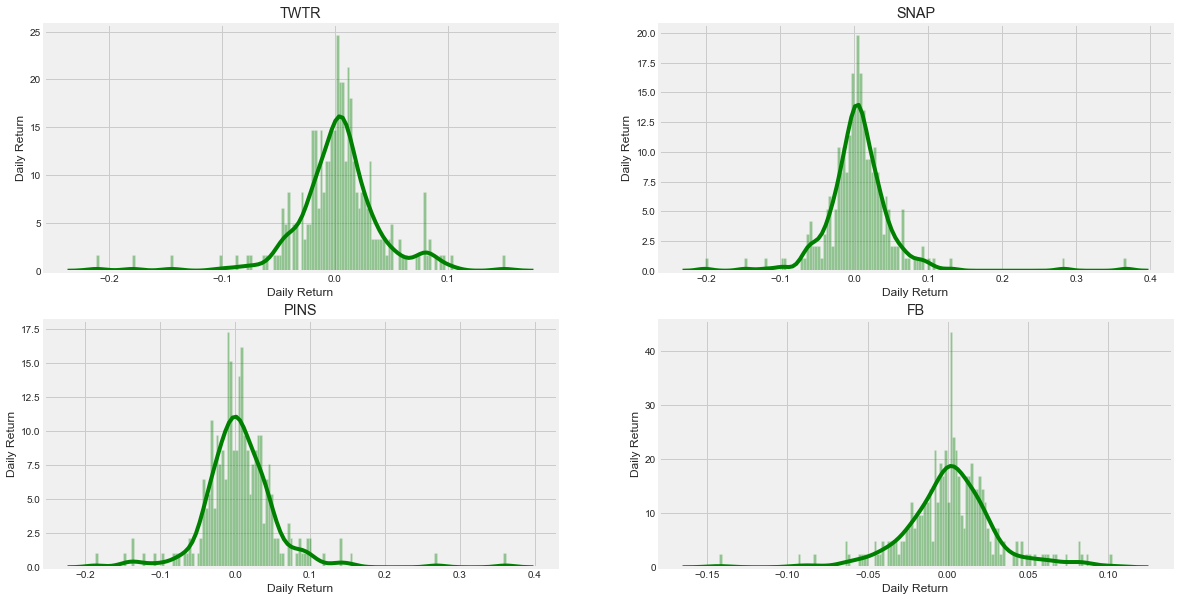

In [45]:
# Note Here i am using of dropna() because dataset has some null values, otherwise the null values can't be read by seaborn

plt.figure(figsize=(18, 10))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    sns.distplot(company['Daily Return'].dropna(), bins=150, color='green')
    plt.ylabel('Daily Return')
    plt.title(f'{company_name[i - 1]}')

In [46]:
### Is their any correlation between different stocks closing prices?

In [47]:
# Fetching all the closing prices for the companies stock list into a new DataFrame
closing_df = DataReader(tech_list, 'yahoo', start, end)['Adj Close']
closing_df.head() 

Symbols,TWTR,SNAP,PINS,FB
Date,,,,
2019-12-17,30.700001,15.10,18.209999,198.389999
2019-12-18,31.680000,15.11,18.530001,202.500000
2019-12-19,32.029999,15.46,19.090000,206.059998
2019-12-20,32.130001,15.55,18.980000,206.300003
2019-12-23,32.430000,15.49,18.389999,206.179993


In [48]:
# Creating new dataframe for returns on stock of our companies
tech_rets = closing_df.pct_change()
tech_rets.head()

Symbols,TWTR,SNAP,PINS,FB
Date,,,,
2019-12-17,NaN,NaN,NaN,NaN
2019-12-18,0.031922,0.000662,0.017573,0.020717
2019-12-19,0.011048,0.023163,0.030221,0.017580
2019-12-20,0.003122,0.005821,-0.005762,0.001165
2019-12-23,0.009337,-0.003859,-0.031085,-0.000582


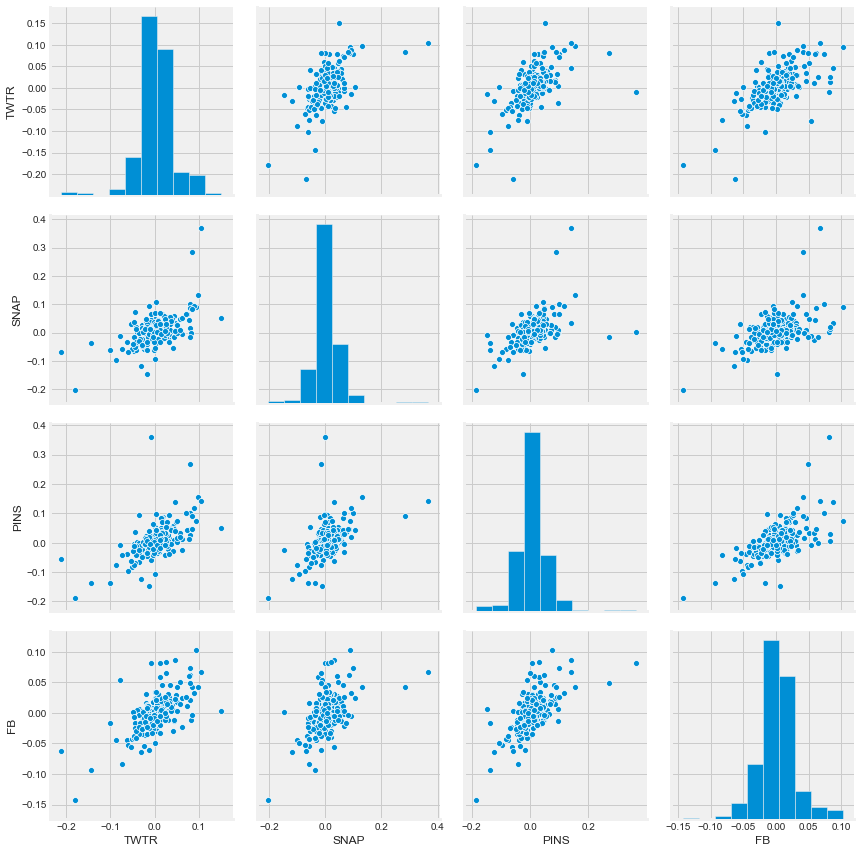

In [49]:
sns.pairplot(tech_rets,palette="bright",diag_kind="auto",size=3)

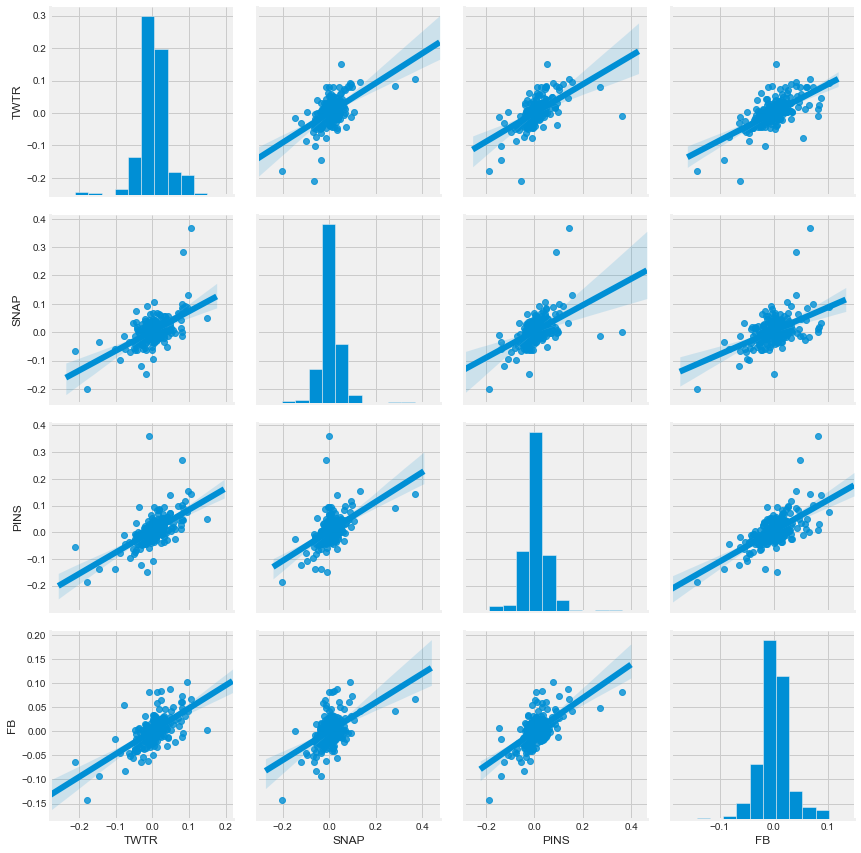

In [50]:
# pairplot with regression line
sns.pairplot(tech_rets,palette="bright",kind="reg",diag_kind="auto",size=3)

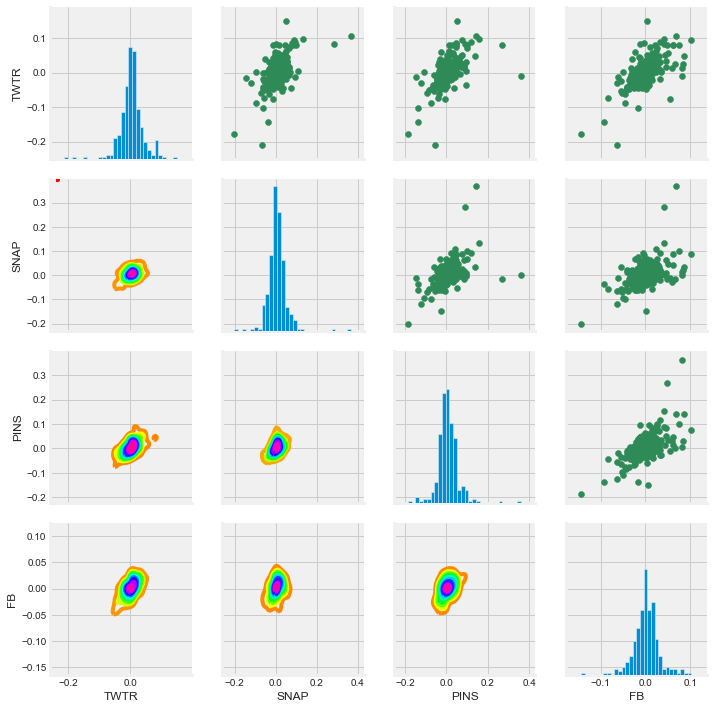

In [51]:
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper to specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='seagreen')

# We can also define the lower triangle in the figure, including the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='hsv')

# The diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

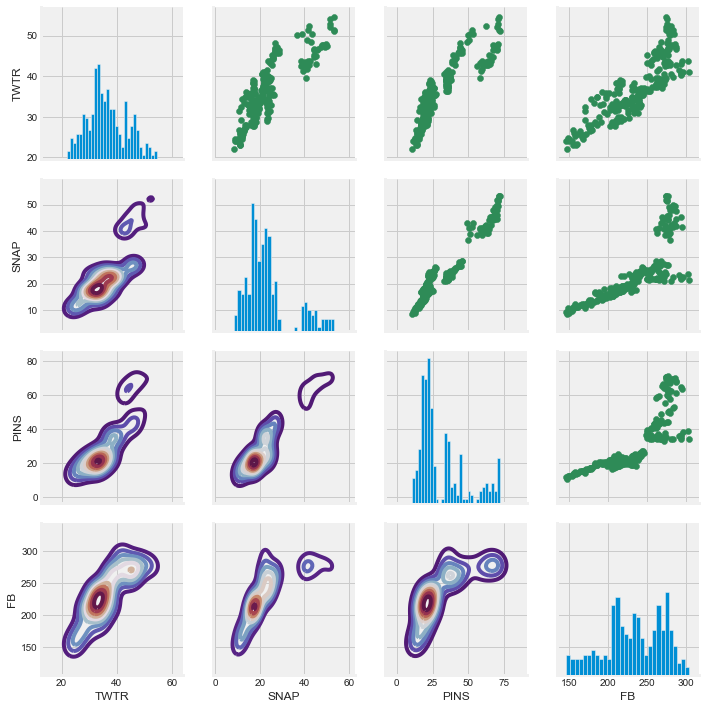

In [52]:
returns_fig = sns.PairGrid(closing_df)
returns_fig.map_upper(plt.scatter,color='seagreen')
returns_fig.map_lower(sns.kdeplot,cmap='twilight_shifted')
returns_fig.map_diag(plt.hist,bins=30)

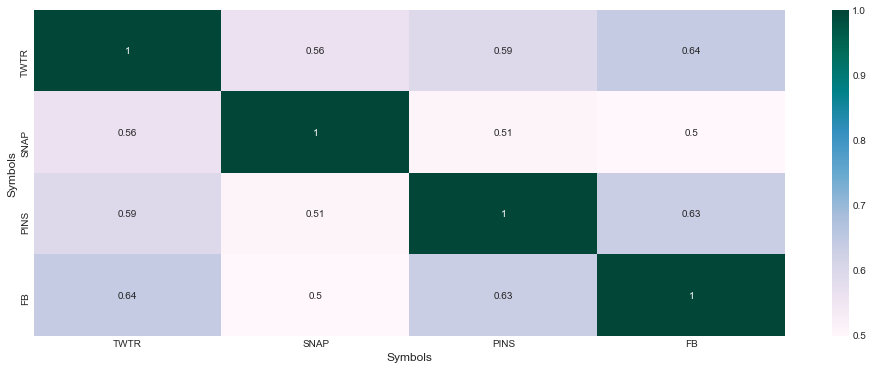

In [53]:
# stock Returns
plt.figure(figsize=(15,6))
sns.heatmap(tech_rets.corr(), annot=True, cmap='PuBuGn')

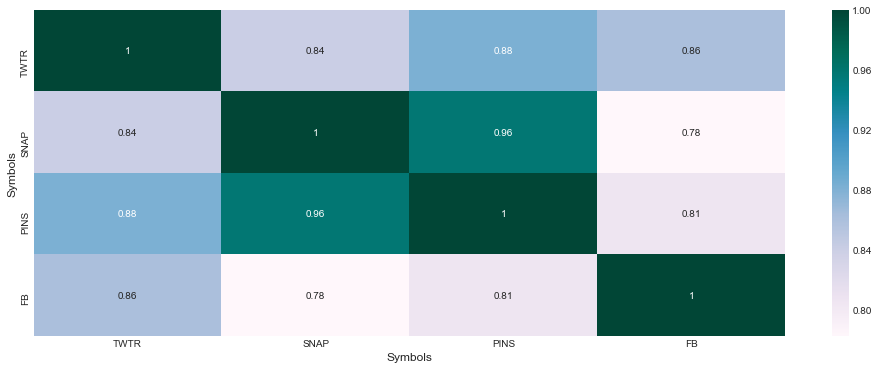

In [54]:
# Closing Price
plt.figure(figsize=(15,6))
sns.heatmap(closing_df.corr(), annot=True, cmap='PuBuGn')

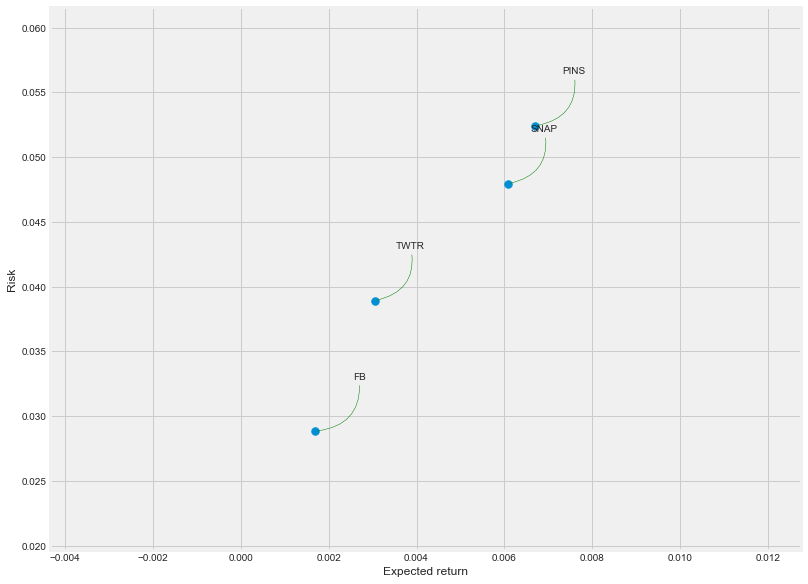

In [55]:
rets = tech_rets.dropna()

area = np.pi*20

plt.figure(figsize=(12, 10))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='green', connectionstyle='arc3,rad=-0.5'))

In [56]:
FB.head()

,High,Low,Open,Close,Volume,Adj Close,company_name,MA for 10 days,MA for 20 days,MA for 50 days,Daily Return
Date,,,,,,,,,,,
2019-12-17,199.000000,196.130005,198.839996,198.389999,10175700,198.389999,FB,NaN,NaN,NaN,NaN
2019-12-18,204.300003,200.089996,200.089996,202.500000,23274400,202.500000,FB,NaN,NaN,NaN,0.020717
2019-12-19,206.300003,202.509995,202.779999,206.059998,16514600,206.059998,FB,NaN,NaN,NaN,0.017580
2019-12-20,207.710007,203.429993,207.479996,206.300003,27306900,206.300003,FB,NaN,NaN,NaN,0.001165
2019-12-23,208.589996,205.679993,206.699997,206.179993,13348900,206.179993,FB,NaN,NaN,NaN,-0.000582


In [57]:
### Now taking Facebook Stocks Data for analysis

In [58]:
fb_df = DataReader('AMZN', data_source='yahoo', start='2001-01-01', end=datetime.now())
fb_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2001-01-02,16.0000,13.6250,15.8125,13.8750,9203500,13.8750
2001-01-03,17.8750,13.5625,13.6250,17.5625,14680400,17.5625
2001-01-04,17.5625,15.4375,17.0000,15.5000,10620500,15.5000
2001-01-05,15.8750,13.5625,15.5000,14.5625,8798800,14.5625
2001-01-08,15.5625,13.7500,14.4375,14.9375,10444700,14.9375


In [59]:
fb_df.reset_index(inplace=True)
fb_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2001-01-02,16.0000,13.6250,15.8125,13.8750,9203500,13.8750
1,2001-01-03,17.8750,13.5625,13.6250,17.5625,14680400,17.5625
2,2001-01-04,17.5625,15.4375,17.0000,15.5000,10620500,15.5000
3,2001-01-05,15.8750,13.5625,15.5000,14.5625,8798800,14.5625
4,2001-01-08,15.5625,13.7500,14.4375,14.9375,10444700,14.9375


In [60]:
# dropping duplicates if any
fb_df = fb_df.drop_duplicates()

# Coverting the datatype of column 'Date' from  object to 'datetime'
fb_df['Date'] = pd.to_datetime(fb_df['Date']).dt.normalize()

# filtering the important columns required
fb_df = fb_df.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# Setting column 'Date' as the index column
fb_df.set_index('Date', inplace= True)

# Sorting the data according to Date
fb_df = fb_df.sort_index(ascending=True, axis=0)
fb_df

,Close,Open,High,Low,Volume
Date,,,,,
2001-01-02,13.875000,15.812500,16.000000,13.625000,9203500
2001-01-03,17.562500,13.625000,17.875000,13.562500,14680400
2001-01-04,15.500000,17.000000,17.562500,15.437500,10620500
2001-01-05,14.562500,15.500000,15.875000,13.562500,8798800
2001-01-08,14.937500,14.437500,15.562500,13.750000,10444700
...,...,...,...,...,...
2020-12-11,3116.419922,3096.659912,3118.669922,3072.820068,3064700
2020-12-14,3156.969971,3143.000000,3190.469971,3126.000000,4155800
2020-12-15,3165.120117,3181.010010,3188.500000,3130.489990,3323700


In [61]:
### Data Merging

In [62]:
# concatenating the datasets stock_price and stock_headlines
stock_news_df = pd.concat([fb_df, news_headlines1], axis=1)

In [63]:
# Take a quick glance on a dataset
stock_news_df.head()

,Close,Open,High,Low,Volume,headline_text
2001-01-01,NaN,NaN,NaN,NaN,NaN,win over cena satisfying but defeating underta...
2001-01-02,13.8750,15.8125,16.0000,13.6250,9203500.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,17.5625,13.6250,17.8750,13.5625,14680400.0,"Powerless north India gropes in the dark,Think..."
2001-01-04,15.5000,17.0000,17.5625,15.4375,10620500.0,The string that pulled Stephen Hawking to Indi...
2001-01-05,14.5625,15.5000,15.8750,13.5625,8798800.0,Light combat craft takes India into club class...


In [64]:
# dropping the null values if any
stock_news_df.dropna(axis=0, inplace=True)

In [65]:
stock_news_df.head()

,Close,Open,High,Low,Volume,headline_text
2001-01-02,13.8750,15.8125,16.0000,13.6250,9203500.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,17.5625,13.6250,17.8750,13.5625,14680400.0,"Powerless north India gropes in the dark,Think..."
2001-01-04,15.5000,17.0000,17.5625,15.4375,10620500.0,The string that pulled Stephen Hawking to Indi...
2001-01-05,14.5625,15.5000,15.8750,13.5625,8798800.0,Light combat craft takes India into club class...
2001-01-08,14.9375,14.4375,15.5625,13.7500,10444700.0,"Sangh Parivar; Babri panel up the ante,Frontru..."


In [66]:
stock_news_df.tail()

,Close,Open,High,Low,Volume,headline_text
2020-06-24,2734.399902,2780.000000,2796.000000,2721.000000,4526600.0,I never thought I had a voice until today: Vid...
2020-06-25,2754.580078,2739.550049,2756.229980,2712.139893,2968700.0,Truck firms look for new export markets to sel...
2020-06-26,2692.870117,2775.060059,2782.570068,2688.000000,6500800.0,Containment zone residents slam high prices ch...
2020-06-29,2680.379883,2690.010010,2696.800049,2630.080078,4223400.0,6 hot and stylish bikini looks of Katrina Kaif...
2020-06-30,2758.820068,2685.070068,2769.629883,2675.030029,3769700.0,"Detective Byomkesh Bakshy!,Edge of Tomorrow,Fi..."


In [67]:
### Sentiment Analysis

In [68]:
# importing requires libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HRISHIKESH\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [69]:
# adding empty sentiment columns to stock_data for later calculation
stock_news_df['compound'] = ''
stock_news_df['negative'] = ''
stock_news_df['neutral'] = ''
stock_news_df['positive'] = ''
stock_news_df.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,13.8750,15.8125,16.0000,13.6250,9203500.0,Status quo will not be disturbed at Ayodhya; s...,,,,
2001-01-03,17.5625,13.6250,17.8750,13.5625,14680400.0,"Powerless north India gropes in the dark,Think...",,,,
2001-01-04,15.5000,17.0000,17.5625,15.4375,10620500.0,The string that pulled Stephen Hawking to Indi...,,,,
2001-01-05,14.5625,15.5000,15.8750,13.5625,8798800.0,Light combat craft takes India into club class...,,,,
2001-01-08,14.9375,14.4375,15.5625,13.7500,10444700.0,"Sangh Parivar; Babri panel up the ante,Frontru...",,,,


In [70]:
# Instantiating the Sentiment Analyzer
sent_analyzer = SentimentIntensityAnalyzer()

In [71]:
# calculating sentiment scores
stock_news_df['compound'] = stock_news_df['headline_text'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

In [72]:
stock_news_df['negative'] = stock_news_df['headline_text'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])

In [73]:
stock_news_df['neutral'] = stock_news_df['headline_text'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])

In [74]:
stock_news_df['positive'] = stock_news_df['headline_text'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])

In [75]:
stock_news_df.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,13.8750,15.8125,16.0000,13.6250,9203500.0,Status quo will not be disturbed at Ayodhya; s...,-0.9621,0.119,0.817,0.064
2001-01-03,17.5625,13.6250,17.8750,13.5625,14680400.0,"Powerless north India gropes in the dark,Think...",0.6322,0.084,0.817,0.098
2001-01-04,15.5000,17.0000,17.5625,15.4375,10620500.0,The string that pulled Stephen Hawking to Indi...,0.6648,0.077,0.843,0.080
2001-01-05,14.5625,15.5000,15.8750,13.5625,8798800.0,Light combat craft takes India into club class...,0.9032,0.105,0.746,0.149
2001-01-08,14.9375,14.4375,15.5625,13.7500,10444700.0,"Sangh Parivar; Babri panel up the ante,Frontru...",-0.9638,0.119,0.855,0.026


In [120]:
### Finalising Stock Data and writing to Disk

In [76]:
# dropping the 'headline_text' which is unwanted now
stock_news_df.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_news_df = stock_news_df[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_news_df.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2001-01-02,13.8750,-0.9621,0.119,0.817,0.064,15.8125,16.0000,13.6250,9203500.0
2001-01-03,17.5625,0.6322,0.084,0.817,0.098,13.6250,17.8750,13.5625,14680400.0
2001-01-04,15.5000,0.6648,0.077,0.843,0.080,17.0000,17.5625,15.4375,10620500.0
2001-01-05,14.5625,0.9032,0.105,0.746,0.149,15.5000,15.8750,13.5625,8798800.0
2001-01-08,14.9375,-0.9638,0.119,0.855,0.026,14.4375,15.5625,13.7500,10444700.0


In [79]:
#Saving the prepared stock_data to disk
stock_news_df.to_csv('stock_data1.csv')

In [80]:
### Reading Stored Stock Data 

In [81]:
stock_news_df = pd.read_csv('stock_data1.csv', index_col = False)

In [82]:
stock_news_df.head()

,Unnamed: 0,Close,compound,negative,neutral,positive,Open,High,Low,Volume
0,2001-01-02,13.8750,-0.9621,0.119,0.817,0.064,15.8125,16.0000,13.6250,9203500.0
1,2001-01-03,17.5625,0.6322,0.084,0.817,0.098,13.6250,17.8750,13.5625,14680400.0
2,2001-01-04,15.5000,0.6648,0.077,0.843,0.080,17.0000,17.5625,15.4375,10620500.0
3,2001-01-05,14.5625,0.9032,0.105,0.746,0.149,15.5000,15.8750,13.5625,8798800.0
4,2001-01-08,14.9375,-0.9638,0.119,0.855,0.026,14.4375,15.5625,13.7500,10444700.0


In [83]:
# renaming the column
stock_news_df.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_news_df.set_index('Date', inplace=True)

# Visualizing stock_data
stock_news_df.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,13.8750,-0.9621,0.119,0.817,0.064,15.8125,16.0000,13.6250,9203500.0
2001-01-03,17.5625,0.6322,0.084,0.817,0.098,13.6250,17.8750,13.5625,14680400.0
2001-01-04,15.5000,0.6648,0.077,0.843,0.080,17.0000,17.5625,15.4375,10620500.0
2001-01-05,14.5625,0.9032,0.105,0.746,0.149,15.5000,15.8750,13.5625,8798800.0
2001-01-08,14.9375,-0.9638,0.119,0.855,0.026,14.4375,15.5625,13.7500,10444700.0


In [84]:
stock_news_df.shape

(4877, 9)

In [85]:
# checking for null values
stock_news_df.isna().any() 

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [86]:
stock_news_df.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4.877000e+03
mean,425.759688,-0.870185,0.125720,0.788116,0.086175,425.695264,430.222942,420.772404,6.396076e+06
std,594.514069,0.453365,0.024431,0.033153,0.020881,594.463671,600.428000,587.877623,5.093926e+06
min,5.970000,-1.000000,0.000000,0.000000,0.000000,5.910000,6.100000,5.510000,8.813000e+05
25%,42.549999,-0.999800,0.112000,0.768000,0.075000,42.439999,43.240002,41.869999,3.543900e+06
50%,160.869995,-0.999000,0.127000,0.785000,0.086000,160.679993,163.539993,157.880005,5.303800e+06
75%,520.719971,-0.994100,0.141000,0.806000,0.096000,520.020020,527.500000,513.039978,7.640400e+06
max,2764.409912,1.000000,0.444000,1.000000,0.608000,2780.000000,2796.000000,2721.000000,1.043292e+08


In [87]:
### Data Preparation

In [231]:
# Preparing and Calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_news_df)-1))

# using 80% of data for training and 20% for testing
train_end = int(data_to_use*0.75)
total_data = len(stock_news_df)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 3657
Number of records in Test Data: 1220


In [232]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_news_df.iloc[start:total_data,0] #close
compound = stock_news_df.iloc[start:total_data,1] #compound
negative = stock_news_df.iloc[start:total_data,2] #neg
neutral = stock_news_df.iloc[start:total_data,3] #neu
positive = stock_news_df.iloc[start:total_data,4] #pos
open_price = stock_news_df.iloc[start:total_data,5] #open
high = stock_news_df.iloc[start:total_data,6] #high
low = stock_news_df.iloc[start:total_data,7] #low
volume = stock_news_df.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2001-01-03      17.562500
2001-01-04      15.500000
2001-01-05      14.562500
2001-01-08      14.937500
2001-01-09      16.375000
                 ...     
2020-06-24    2734.399902
2020-06-25    2754.580078
2020-06-26    2692.870117
2020-06-29    2680.379883
2020-06-30    2758.820068
Name: Close, Length: 4876, dtype: float64

In [233]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()   

In [234]:
data.head()

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2001-01-03,17.5625,15.5000,0.6322,0.6648,14680400.0,13.6250,17.8750,13.5625
2001-01-04,15.5000,14.5625,0.6648,0.9032,10620500.0,17.0000,17.5625,15.4375
2001-01-05,14.5625,14.9375,0.9032,-0.9638,8798800.0,15.5000,15.8750,13.5625
2001-01-08,14.9375,16.3750,-0.9638,-0.9559,10444700.0,14.4375,15.5625,13.7500
2001-01-09,16.3750,16.5000,-0.9559,-0.5719,23455200.0,14.5625,16.6250,14.5625


In [235]:
# setting the target variable as the shifted close_price
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
y = data['close_price_shifted']

In [236]:
x.shape,y.shape

((4875, 7), (4875,))

In [237]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.99159489,  0.6322    ,  0.6648    , ..., -0.99443782,
         -0.99155884, -0.99406921],
        [-0.9930903 ,  0.6648    ,  0.9032    , ..., -0.99200459,
         -0.99178286, -0.99268824],
        [-0.99377003,  0.9032    , -0.9638    , ..., -0.99308602,
         -0.99299258, -0.99406921],
        ...,
        [ 0.9928729 , -0.9999    , -0.9999    , ...,  0.97083732,
          0.97149   ,  0.9934744 ],
        [ 0.94813025, -0.9999    , -0.9997    , ...,  0.99643851,
          0.99037246,  0.97569499],
        [ 0.93907424, -0.9997    , -0.9998    , ...,  0.93512107,
          0.92888638,  0.93303608]]), array([[-0.9930903 ],
        [-0.99377003],
        [-0.99349814],
        ...,
        [ 0.94813025],
        [ 0.93907424],
        [ 0.9959471 ]]))

In [238]:
### Dividing the dataset into Training and Test

In [239]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (3657, 7) and y: (3657, 1)
Number of rows and columns in the Test set X: (1217, 7) and y: (1217, 1)


In [240]:
###Reshaping the features

In [241]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (3657, 7, 1)
Shape of Test set X: (1217, 7, 1)


In [242]:
### News_Stock Data Modelling

In [243]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(0)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 7, 100)            40800     
_________________________________________________________________
dropout_47 (Dropout)         (None, 7, 100)            0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 7, 100)            80400     
_________________________________________________________________
dropout_48 (Dropout)         (None, 7, 100)            0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_49 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)               

In [244]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=2, verbose=1)

Train on 2925 samples, validate on 732 samples
Epoch 1/5
2925/2925 [==============================] - 34s 12ms/step - loss: 0.0089 - val_loss: 0.0330
Epoch 2/5
2925/2925 [==============================] - 34s 12ms/step - loss: 0.0038 - val_loss: 0.0383
Epoch 3/5
2925/2925 [==============================] - 34s 12ms/step - loss: 0.0033 - val_loss: 0.0264
Epoch 4/5
2925/2925 [==============================] - 35s 12ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 5/5
2925/2925 [==============================] - 34s 12ms/step - loss: 0.0013 - val_loss: 0.0025


In [245]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


In [246]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:4]

Predictions:


array([[435.40094],
       [440.69226],
       [427.13782],
       [430.41052]], dtype=float32)

In [247]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

1217/1217 [==============================] - 4s 3ms/step
Train Loss = 0.001
Test Loss = 0.279


In [248]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 739.1359


In [249]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

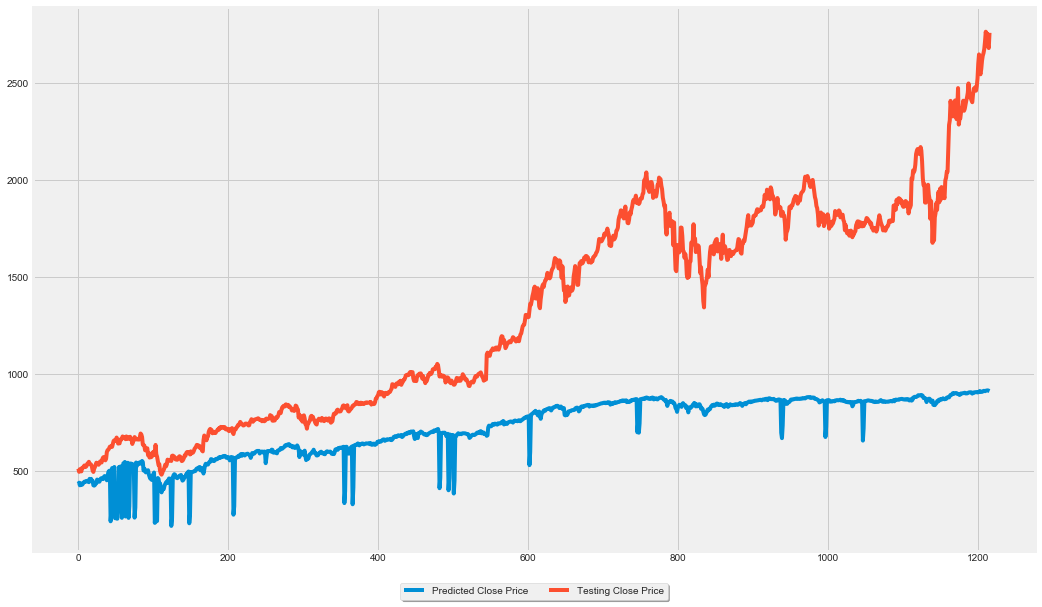

In [250]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

### Conclusion
##### I have successfully created a model for stock price/performance prediction using numerical analysis of historical stock prices and sentimental analysis of news headlines.

#### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# <center><font color=5B1736>Thank You!</font></center>